Columns:

`Education` : The educational qualifications of employees, including degree, institution, and field of study.

`Joining Year` : The year each employee joined the company, indicating their length of service.

`City` : The location or city where each employee is based or works.

`Payment Tier` : Categorization of employees into different salary tiers. (數字越小薪資層級越高)

`Age` : The age of each employee, providing demographic insights.

`Gender` : Gender identity of employees, promoting diversity analysis.

`Ever Benched` : Indicates if an employee has ever been temporarily without assigned work.

`Experience in Current Domain` : The number of years of experience employees have in their current field.

`Leave or Not` : a target column 預測是否離職

In [52]:
#Data Handling
import numpy as np 
import pandas as pd 

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#statistics
from scipy import stats

In [53]:
data = pd.read_csv('Employee.csv')
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [55]:
data['LeaveOrNot'] = data['LeaveOrNot'].astype(object)
data['PaymentTier'] = data['PaymentTier'].astype(object)

In [56]:
data.shape

(4653, 9)

In [65]:
import os
pic_path = './picture/'

In [66]:
tmp  = list(data.dtypes != np.int64)
cols = data.columns[tmp].tolist()
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'LeaveOrNot']


In [67]:
tmp  = list(data.dtypes == np.int64)
num_cols = data.columns[tmp].tolist()
print(num_cols)

['JoiningYear', 'Age', 'ExperienceInCurrentDomain']


In [68]:
def plot_hist(name):
    sns.countplot(x = name, data = data)
    plt.ylabel('Total')
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

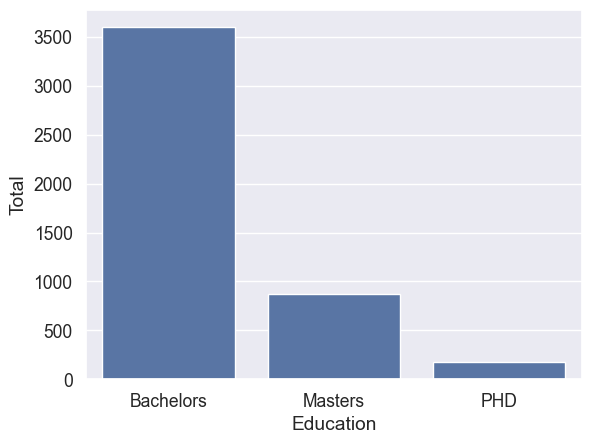

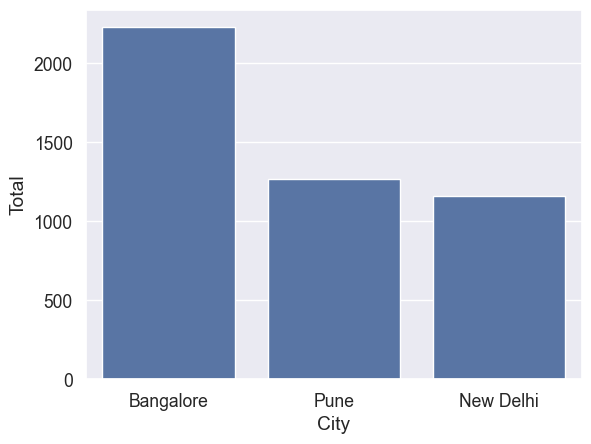

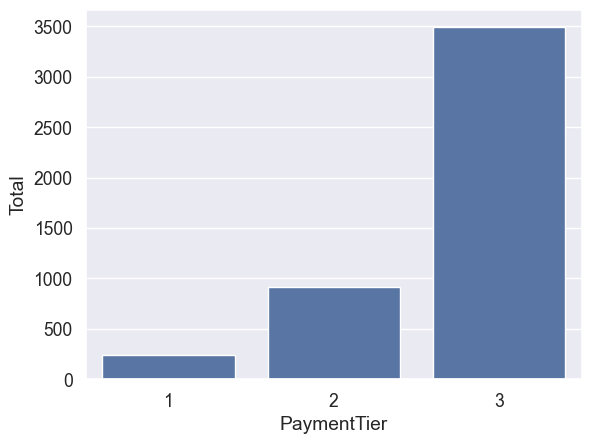

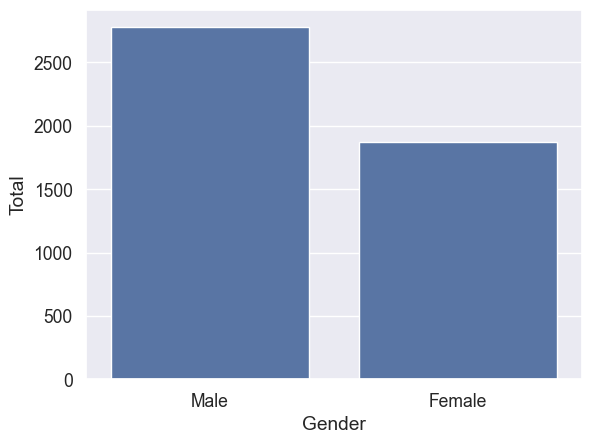

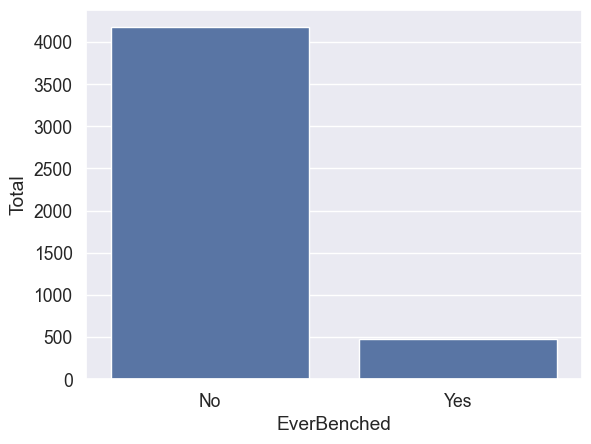

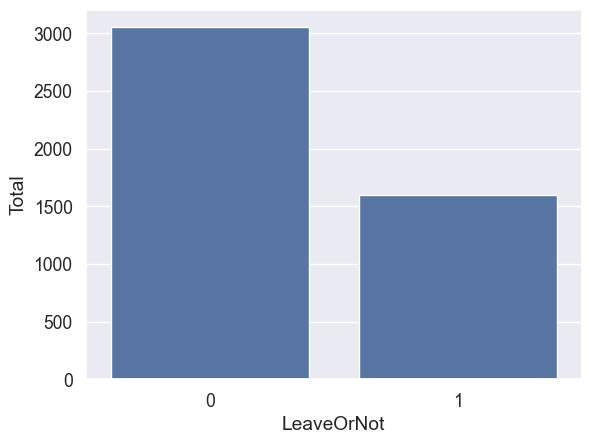

<Figure size 640x480 with 0 Axes>

In [69]:
tmp = list(map(plot_hist, cols))

In [70]:
def plot_box(name):
    sns.boxplot(data = data, x = name)
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

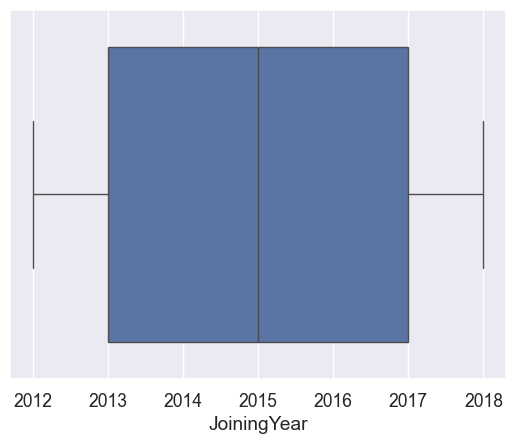

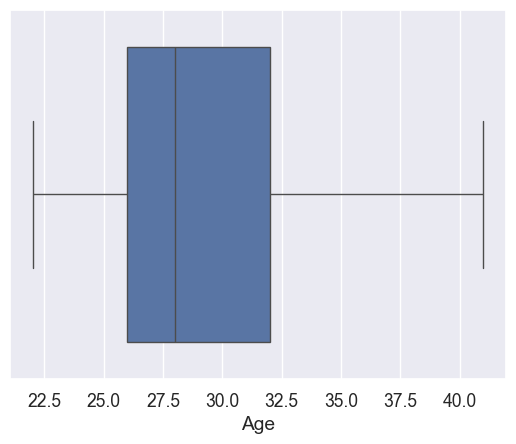

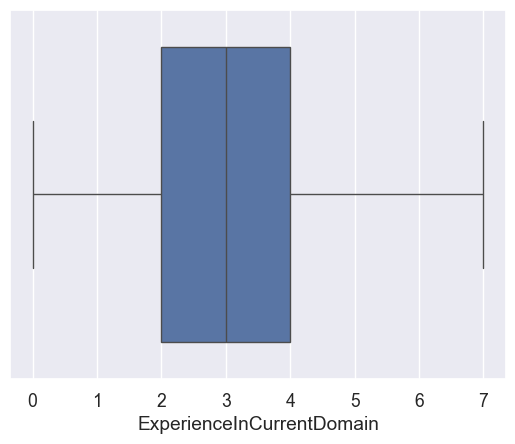

<Figure size 640x480 with 0 Axes>

In [71]:
tmp = list(map(plot_box, num_cols))

In [72]:
cols.remove('LeaveOrNot')
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched']


In [73]:
def plot_bi_hist(name):
    sns.countplot(x = name, data = data, hue = 'LeaveOrNot')
    plt.ylabel('Total')
    plt.xlabel(name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

In [74]:
def plot_bi_box(name):
    sns.boxplot(data = data, x = 'LeaveOrNot', y = name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

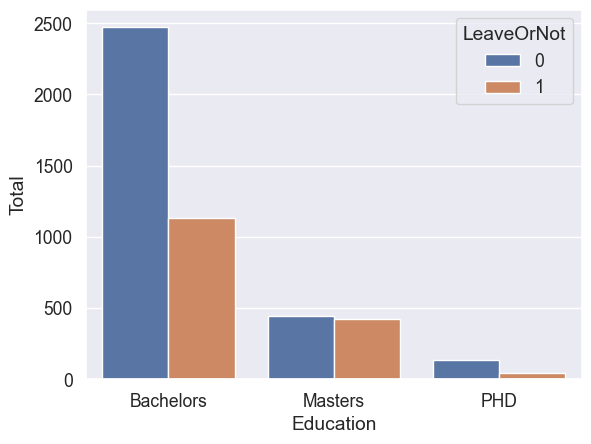

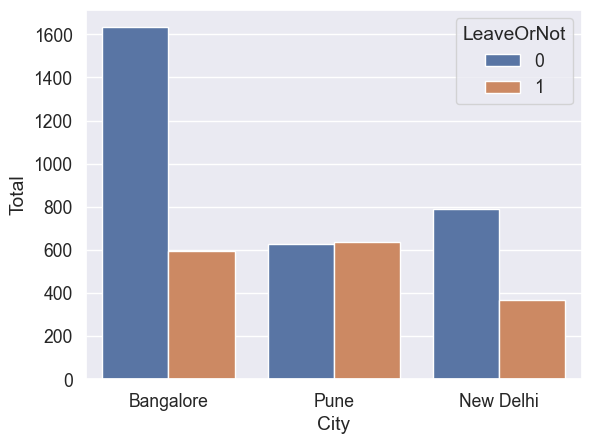

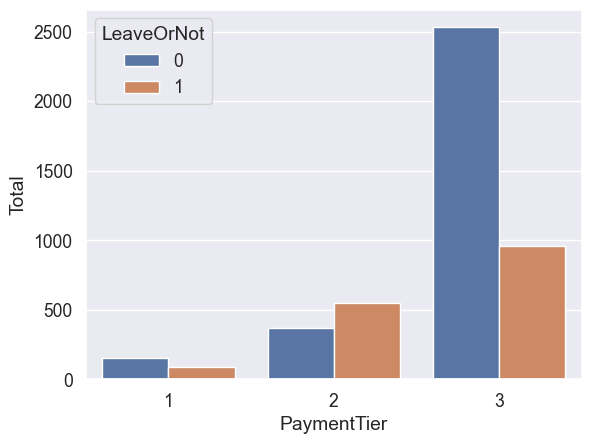

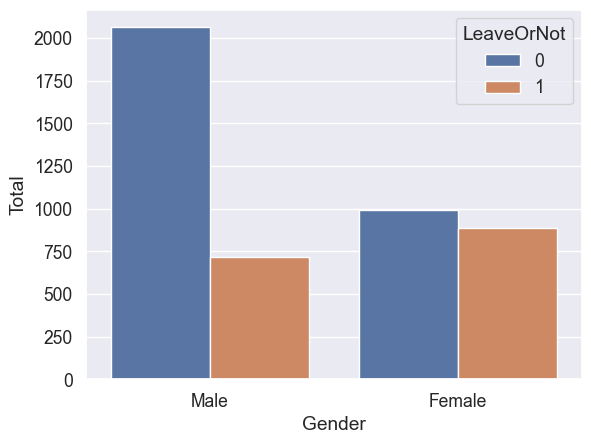

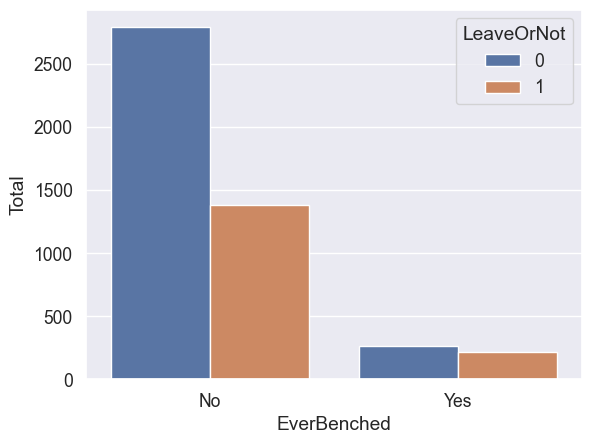

<Figure size 640x480 with 0 Axes>

In [75]:
tmp = list(map(plot_bi_hist, cols))

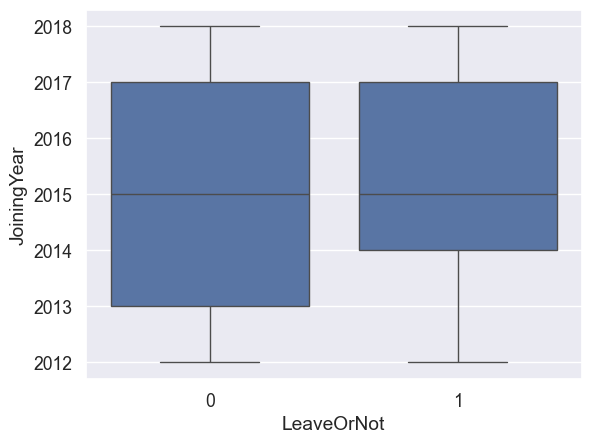

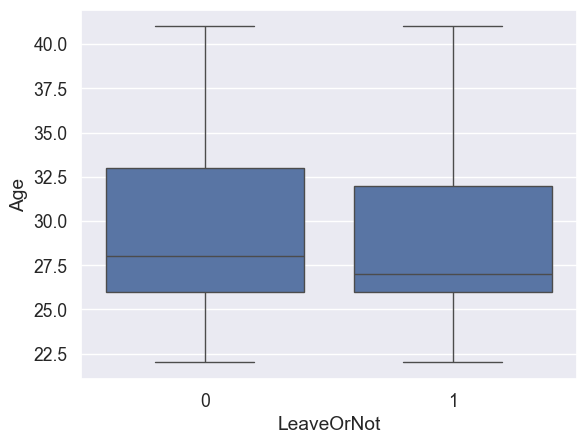

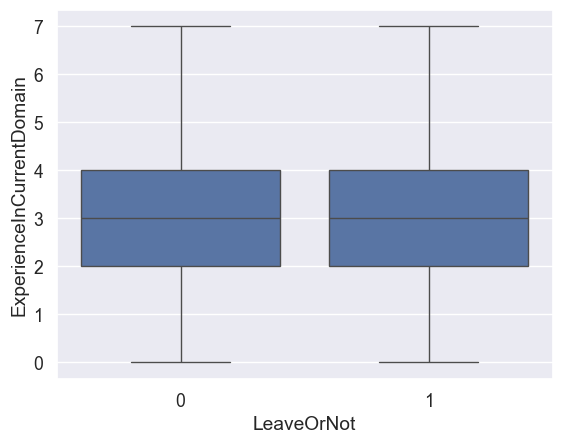

<Figure size 640x480 with 0 Axes>

In [76]:
tmp = list(map(plot_bi_box, num_cols))

In [77]:
def stats_test(col):
  if data[col].dtype == np.int64 or data[col].dtype == np.float64:
    tmp0 = data.loc[data['LeaveOrNot'] == 0, col].values
    tmp1 = data.loc[data['LeaveOrNot'] == 1, col].values

    result = stats.ttest_ind(tmp0, tmp1)[0:2]

  else:
    contingency_table = data.pivot_table(index = [col], columns = 'LeaveOrNot', values = 'Age', aggfunc = 'count')
    contingency_table = contingency_table.fillna(0)
    contingency_table = contingency_table.values

    result = stats.chi2_contingency(contingency_table, correction = False)[0:2]

  return result

In [78]:
all_cols = data.columns[:-1].tolist()
results = {c: stats_test(c) for c in all_cols}
print(results)

{'Education': (101.83014138498626, 7.724417739147332e-23), 'JoiningYear': (-12.601776125876363, 7.90161666436133e-36), 'City': (206.15885400194648, 1.7106992135618012e-45), 'PaymentTier': (338.6305486794045, 2.9329904732261673e-74), 'Age': (3.491261554959713, 0.0004852123420648861), 'Gender': (226.64164837884488, 3.219334068915125e-51), 'EverBenched': (28.627472496502868, 8.772866504669789e-08), 'ExperienceInCurrentDomain': (2.081296101564669, 0.037461383540452)}


全部都顯著，加上feature selection應該要來回對照，所以就先全部餵進去吧

In [79]:
seed = 1126

In [80]:
x = data.drop(['LeaveOrNot'], axis=1)
y = data['LeaveOrNot'].astype(np.int64)

In [81]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed, stratify = y)

如果你是用lightgbm或catboost的話，他可以直接吃categorical data

用簡單的leave-one-out target encoding encode categorical data

In [83]:
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [84]:
encoder = ce.LeaveOneOutEncoder(cols = cols, sigma = 0.05)
encoder.fit(x_train, y_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [85]:
x_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
939,0.30982,2017,0.496538,0.271813,27,0.256901,0.33094,5
3326,0.30982,2017,0.496538,0.599185,33,0.476287,0.33094,2
3113,0.30982,2014,0.269016,0.271813,40,0.476287,0.33094,0
69,0.50142,2017,0.269016,0.271813,40,0.476287,0.33094,2
3546,0.50142,2018,0.496538,0.271813,31,0.256901,0.33094,2


將數值資料standardize

In [86]:
from sklearn.preprocessing import StandardScaler

std_encoder = StandardScaler()
x_train = std_encoder.fit_transform(x_train)
x_test = std_encoder.transform(x_test)

In [87]:
x_train[0:3]

array([[-0.44294974,  1.03450786,  1.59624031, -0.55293904, -0.49837554,
        -0.81065918, -0.33720078,  1.34599141],
       [-0.44294974,  1.03450786,  1.59624031,  1.95811516,  0.74294975,
         1.23356403, -0.33720078, -0.59028018],
       [-0.44294974, -0.57767843, -0.7831341 , -0.55293904,  2.19116258,
         1.23356403, -0.33720078, -1.88112791]])

In [88]:
print(x_train.shape)
print(x_test.shape)

(3722, 8)
(931, 8)


In [89]:
x_train_copy = pd.DataFrame(x_train, columns = data.columns[:-1])
x_train_copy.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,-0.442950,1.034508,1.596240,-0.552939,-0.498376,-0.810659,-0.337201,1.345991
1,-0.442950,1.034508,1.596240,1.958115,0.742950,1.233564,-0.337201,-0.590280
2,-0.442950,-0.577678,-0.783134,-0.552939,2.191163,1.233564,-0.337201,-1.881128
3,2.047278,1.034508,-0.783134,-0.552939,2.191163,1.233564,-0.337201,-0.590280
4,2.047278,1.571903,1.596240,-0.552939,0.329175,-0.810659,-0.337201,-0.590280


<Axes: >

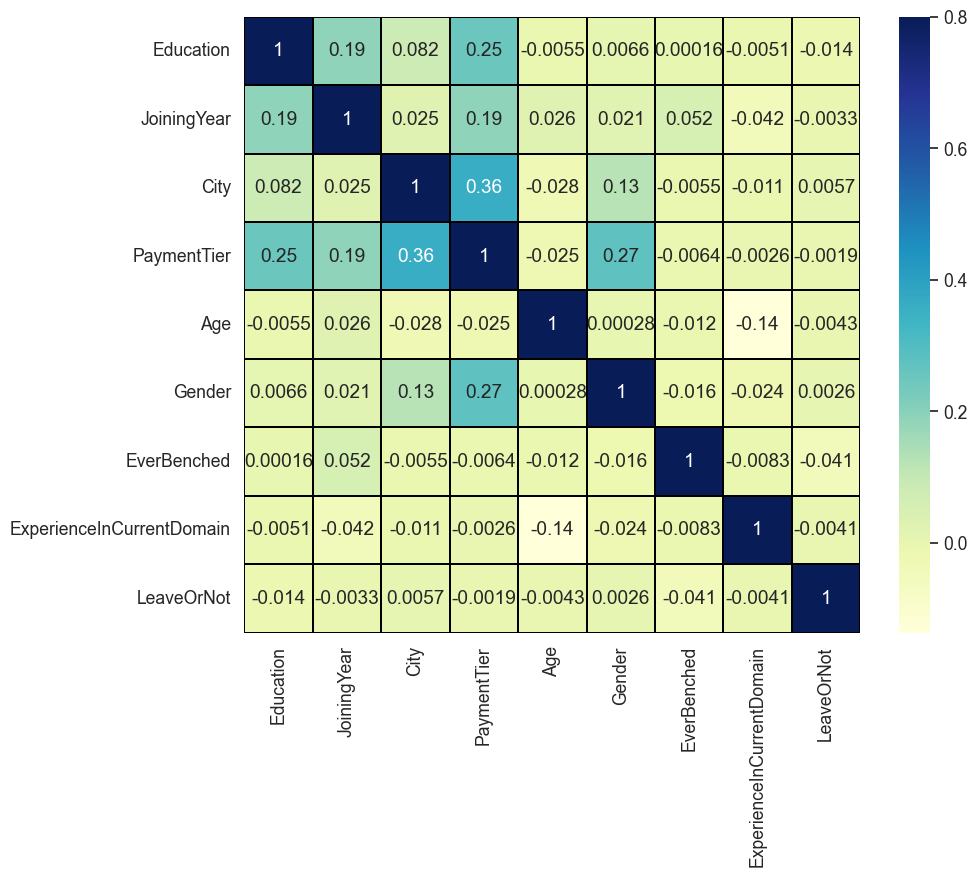

In [90]:
sns.set(font_scale = 1.15)
plt.figure(figsize = (10, 8))
sns.heatmap(pd.concat([x_train_copy, y_train], axis = 1).corr(), vmax = 0.8, linewidths = 0.01, square = True, 
            annot = True, cmap='YlGnBu',
linecolor = 'black')

用border line smote去做upsampling

In [91]:
from imblearn.over_sampling import BorderlineSMOTE

smote_enn = BorderlineSMOTE(random_state = seed)
x_train_resampled, y_train_resampled = smote_enn.fit_resample(x_train, y_train)

直接補到0 1同樣數量

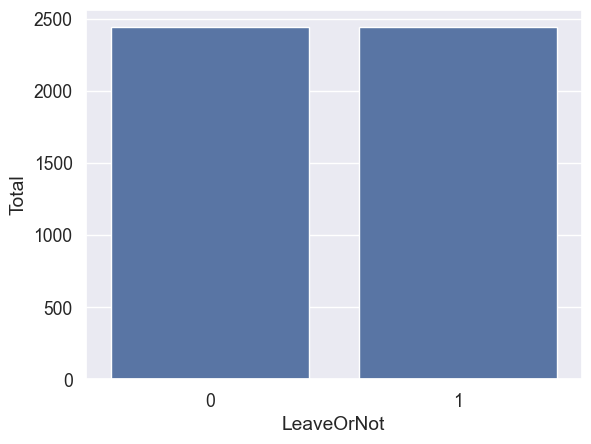

In [92]:
sns.countplot(x = y_train_resampled)
plt.ylabel('Total')
plt.xlabel('LeaveOrNot')
plt.show()

In [93]:
y_train_resampled.shape

(4884,)

## SVM, MLP, GBM

In [94]:
x_train_resampled

array([[-0.44294974,  1.03450786,  1.59624031, ..., -0.81065918,
        -0.33720078,  1.34599141],
       [-0.44294974,  1.03450786,  1.59624031, ...,  1.23356403,
        -0.33720078, -0.59028018],
       [-0.44294974, -0.57767843, -0.7831341 , ...,  1.23356403,
        -0.33720078, -1.88112791],
       ...,
       [-0.44294974, -0.040283  ,  1.59624031, ...,  1.23356403,
         2.96559216, -1.19906196],
       [-0.44294974, -0.93119712, -0.7831341 , ..., -0.81065918,
        -0.33720078,  1.78767151],
       [ 2.0472779 ,  1.03450786, -0.23137072, ...,  1.23356403,
        -0.33720078, -1.23570405]])

In [143]:
## 定義評估函數
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from pprint import pprint

def eval_pipeline(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict = True).get('0')
    auc = roc_auc_score(y_test, y_pred)
    report['auc'] = auc
    pprint(report)
    return report

def plot_confusion_matrix(y_test, y_pred, title = None):
    title = 'Confusion Matrix' + title if title else 'Confusion Matrix'
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
def plot_roc_curve(y_test, y_pred, title):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = 'ROC Curve' + title if title else 'ROC Curve'
    plt.title('ROC Curve')
    plt.show()

### SVM

In [144]:
from sklearn import svm

def svm_model(kernel, x_train, y_train, x_test, y_test,):
    print("Kernel: ", kernel)
    clf_svm = svm.SVC(random_state = seed, kernel=kernel)
    clf_svm.fit(x_train, y_train)

    y_pred = clf_svm.predict(x_test)
    report = eval_pipeline(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, kernel)
    return report

In [145]:
clf = svm.SVC()
clf.fit(x_train_resampled, y_train_resampled)
y_pred = clf.predict(x_test)

Kernel:  linear
{'auc': 0.6593264116202946,
 'f1-score': 0.7144136078782453,
 'precision': 0.7885375494071146,
 'recall': 0.6530278232405892,
 'support': 611.0}


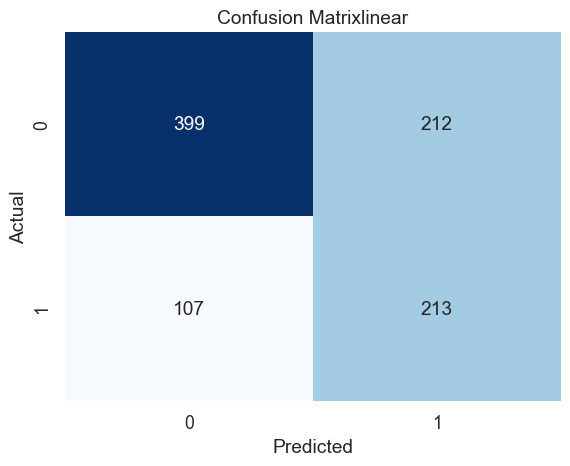



BEST ONE:  {'precision': 0.7885375494071146, 'recall': 0.6530278232405892, 'f1-score': 0.7144136078782453, 'support': 611.0, 'auc': 0.6593264116202946}
Kernel:  poly
{'auc': 0.7703994476268413,
 'f1-score': 0.8382838283828383,
 'precision': 0.8452579034941764,
 'recall': 0.8314238952536824,
 'support': 611.0}


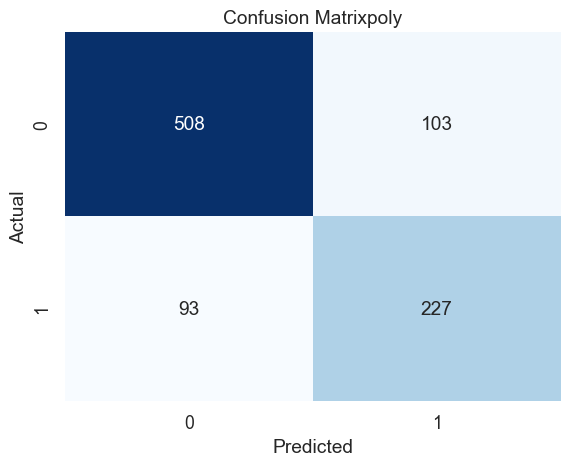



BEST ONE:  {'precision': 0.8452579034941764, 'recall': 0.8314238952536824, 'f1-score': 0.8382838283828383, 'support': 611.0, 'auc': 0.7703994476268413}
Kernel:  rbf
{'auc': 0.7959211333878887,
 'f1-score': 0.8455696202531645,
 'precision': 0.872822299651568,
 'recall': 0.8199672667757774,
 'support': 611.0}


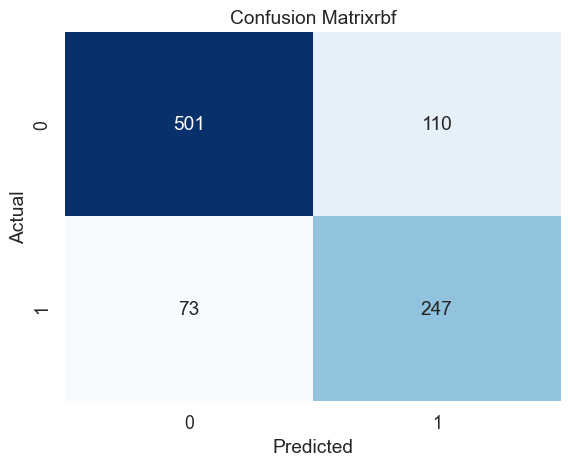



BEST ONE:  {'precision': 0.872822299651568, 'recall': 0.8199672667757774, 'f1-score': 0.8455696202531645, 'support': 611.0, 'auc': 0.7959211333878887}
Kernel:  sigmoid
{'auc': 0.41566591653027823,
 'f1-score': 0.5073800738007379,
 'precision': 0.5813953488372093,
 'recall': 0.4500818330605565,
 'support': 611.0}


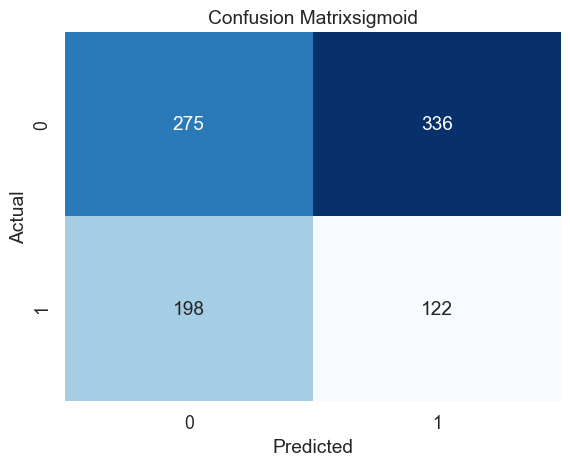



BEST ONE:  {'precision': 0.872822299651568, 'recall': 0.8199672667757774, 'f1-score': 0.8455696202531645, 'support': 611.0, 'auc': 0.7959211333878887}


In [149]:
# 根據情況調整參數
# 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_svm_repo = None

# SMOTE後的資料
for kernel in kernels:
    if best_svm_repo is None:
        best_svm_repo = svm_model(kernel, x_train_resampled, y_train_resampled, x_test, y_test)
    else:
        cur_svm_repo = svm_model(kernel, x_train_resampled, y_train_resampled, x_test, y_test)
        if cur_svm_repo['auc'] > best_svm_repo['auc']:
            best_svm_repo = cur_svm_repo
    print("\n\nBEST ONE: ", best_svm_repo)

使用 Radial Basis Function (RBF) 的效果最佳。

Kernel:  linear
{'auc': 0.6105743657937808,
 'f1-score': 0.7911764705882353,
 'precision': 0.7182910547396528,
 'recall': 0.8805237315875614,
 'support': 611.0}


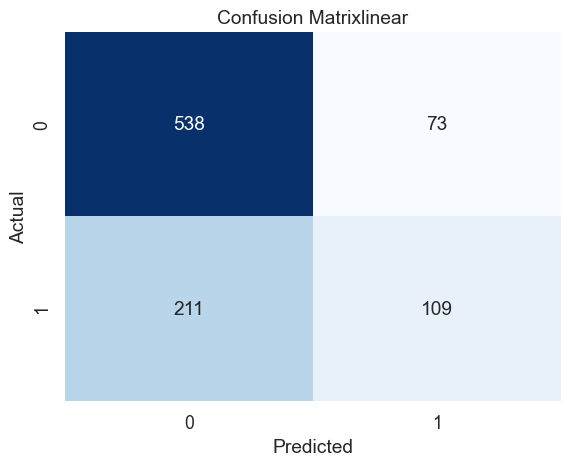



BEST ONE:  {'precision': 0.872822299651568, 'recall': 0.8199672667757774, 'f1-score': 0.8455696202531645, 'support': 611.0, 'auc': 0.7959211333878887}
Kernel:  poly
{'auc': 0.7787975654664484,
 'f1-score': 0.8847023360964581,
 'precision': 0.8198324022346368,
 'recall': 0.9607201309328969,
 'support': 611.0}


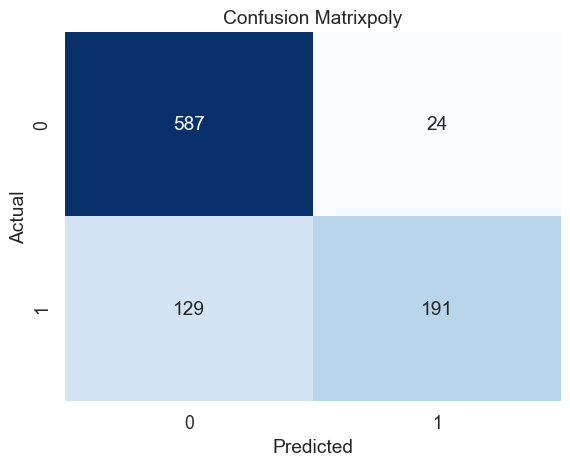



BEST ONE:  {'precision': 0.872822299651568, 'recall': 0.8199672667757774, 'f1-score': 0.8455696202531645, 'support': 611.0, 'auc': 0.7959211333878887}
Kernel:  rbf
{'auc': 0.7975475654664484,
 'f1-score': 0.8927756653992396,
 'precision': 0.8338068181818182,
 'recall': 0.9607201309328969,
 'support': 611.0}


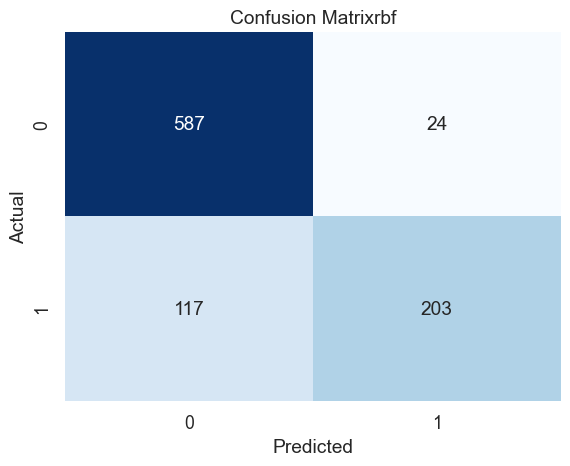



BEST ONE:  {'precision': 0.8338068181818182, 'recall': 0.9607201309328969, 'f1-score': 0.8927756653992396, 'support': 611.0, 'auc': 0.7975475654664484}
Kernel:  sigmoid
{'auc': 0.4462331219312602,
 'f1-score': 0.6232709519934907,
 'precision': 0.6197411003236246,
 'recall': 0.6268412438625205,
 'support': 611.0}


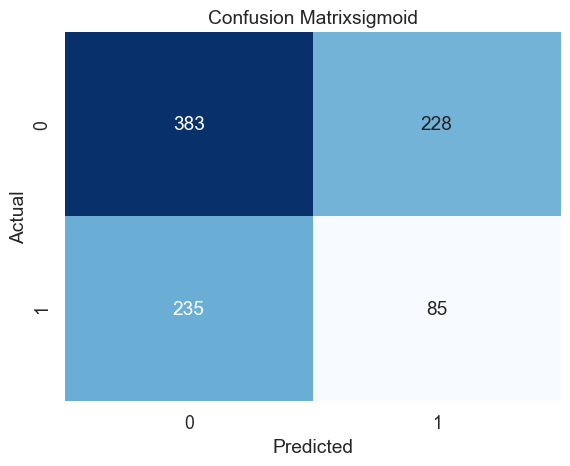



BEST ONE:  {'precision': 0.8338068181818182, 'recall': 0.9607201309328969, 'f1-score': 0.8927756653992396, 'support': 611.0, 'auc': 0.7975475654664484}


In [150]:
for kernel in kernels:
    if best_svm_repo is None:
        best_svm_repo = svm_model(kernel, x_train, y_train, x_test, y_test)
    else:
        cur_svm_repo = svm_model(kernel, x_train, y_train, x_test, y_test)
        if cur_svm_repo['auc'] > best_svm_repo['auc']:
            best_svm_repo = cur_svm_repo
    print("\n\nBEST ONE: ", best_svm_repo)

### MLP

In [152]:
from sklearn.neural_network import MLPClassifier

def mlp_model(x_train, y_train, x_test, y_test, max_iter=100):
    clf_mlp = MLPClassifier(random_state = seed, max_iter=max_iter, momentum=0.99, early_stopping=True, learning_rate_init=0.001)
    clf_mlp.fit(x_train, y_train)

    y_pred = clf_mlp.predict(x_test)
    repo = eval_pipeline(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred)
    return repo


{'auc': 0.7509871112929624,
 'f1-score': 0.790820829655781,
 'precision': 0.8582375478927203,
 'recall': 0.7332242225859247,
 'support': 611.0}


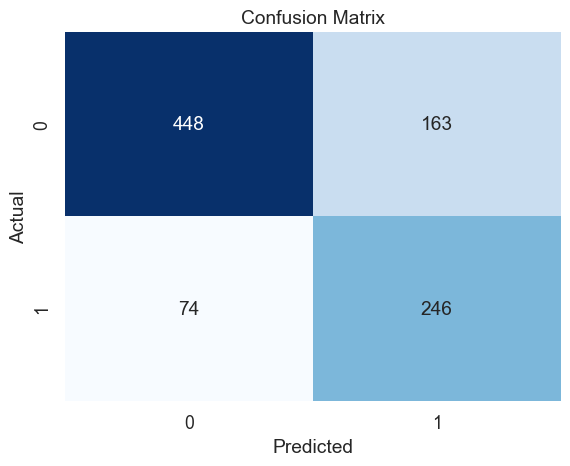



BEST ONE:  {'precision': 0.8582375478927203, 'recall': 0.7332242225859247, 'f1-score': 0.790820829655781, 'support': 611.0, 'auc': 0.7509871112929624}
{'auc': 0.7509871112929624,
 'f1-score': 0.790820829655781,
 'precision': 0.8582375478927203,
 'recall': 0.7332242225859247,
 'support': 611.0}


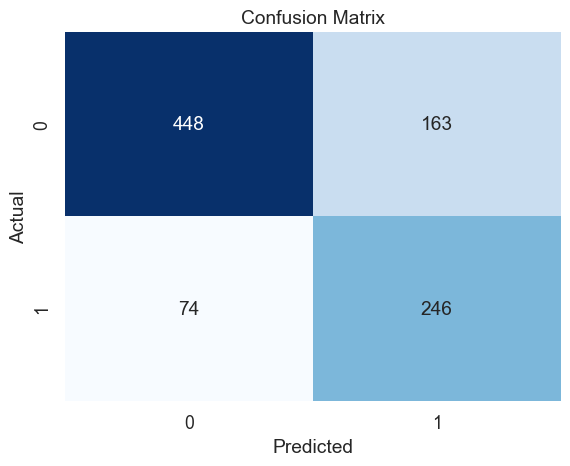



BEST ONE:  {'precision': 0.8582375478927203, 'recall': 0.7332242225859247, 'f1-score': 0.790820829655781, 'support': 611.0, 'auc': 0.7509871112929624}
{'auc': 0.7509871112929624,
 'f1-score': 0.790820829655781,
 'precision': 0.8582375478927203,
 'recall': 0.7332242225859247,
 'support': 611.0}


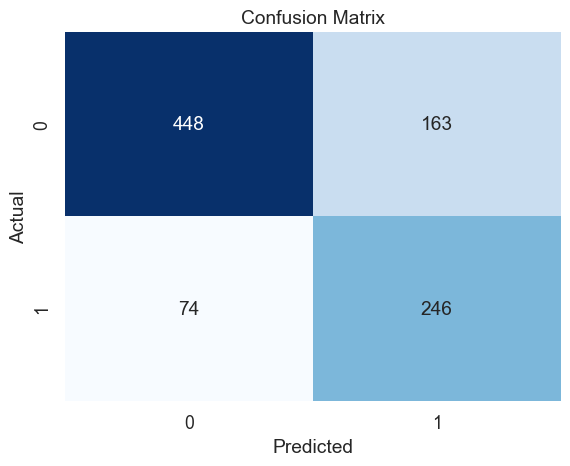



BEST ONE:  {'precision': 0.8582375478927203, 'recall': 0.7332242225859247, 'f1-score': 0.790820829655781, 'support': 611.0, 'auc': 0.7509871112929624}


In [153]:
# SMOTE
best_mlp_repo = None
for max_iter in range(200, 601, 200):
    if best_mlp_repo is None:
        best_mlp_repo = mlp_model(x_train_resampled, y_train_resampled, x_test, y_test, max_iter)
    else:
        cur_mlp_repo = mlp_model(x_train_resampled, y_train_resampled, x_test, y_test, max_iter)
        if cur_mlp_repo['auc'] > best_mlp_repo['auc']:
            best_mlp_repo = cur_mlp_repo
    print("\n\nBEST ONE: ", best_mlp_repo)

{'auc': 0.7828176145662847,
 'f1-score': 0.8774094063222823,
 'precision': 0.8294460641399417,
 'recall': 0.9312602291325696,
 'support': 611.0}


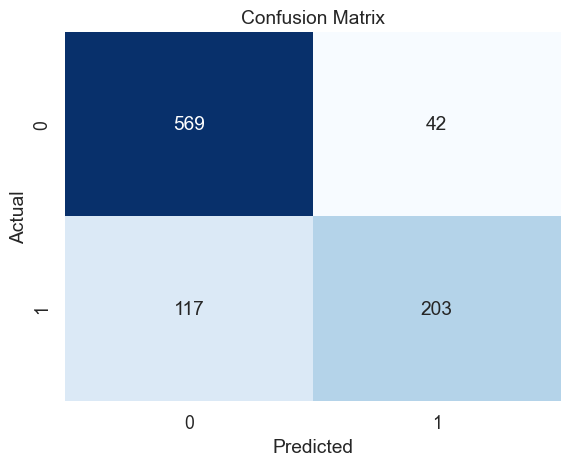



BEST ONE:  {'precision': 0.8294460641399417, 'recall': 0.9312602291325696, 'f1-score': 0.8774094063222823, 'support': 611.0, 'auc': 0.7828176145662847}
{'auc': 0.7828176145662847,
 'f1-score': 0.8774094063222823,
 'precision': 0.8294460641399417,
 'recall': 0.9312602291325696,
 'support': 611.0}


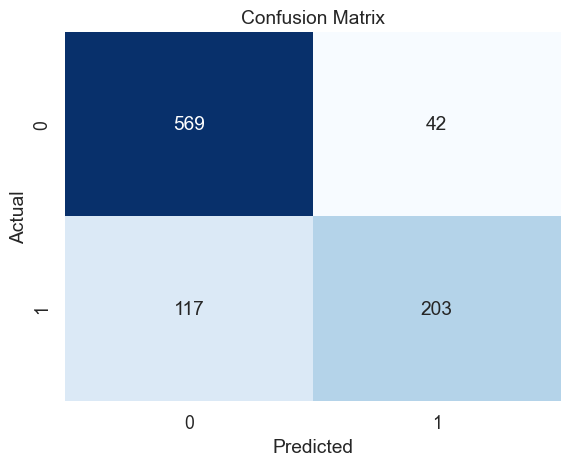



BEST ONE:  {'precision': 0.8294460641399417, 'recall': 0.9312602291325696, 'f1-score': 0.8774094063222823, 'support': 611.0, 'auc': 0.7828176145662847}
{'auc': 0.7828176145662847,
 'f1-score': 0.8774094063222823,
 'precision': 0.8294460641399417,
 'recall': 0.9312602291325696,
 'support': 611.0}


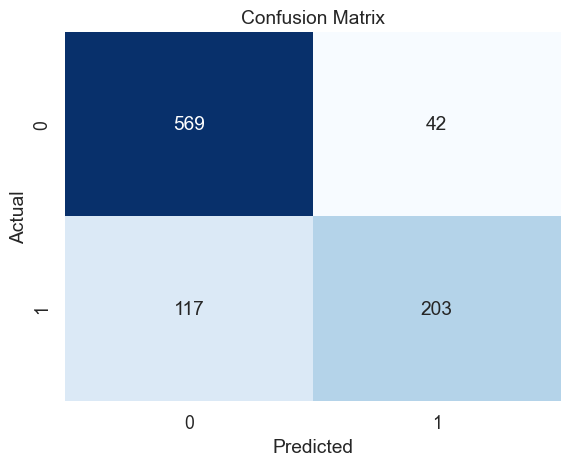



BEST ONE:  {'precision': 0.8294460641399417, 'recall': 0.9312602291325696, 'f1-score': 0.8774094063222823, 'support': 611.0, 'auc': 0.7828176145662847}


In [154]:
# 未使用SMOTE
for max_iter in range(200, 601, 200):
    if best_mlp_repo is None:
        best_mlp_repo = mlp_model(x_train, y_train, x_test, y_test, max_iter)
    else:
        cur_mlp_repo = mlp_model(x_train, y_train, x_test, y_test, max_iter)
        if cur_mlp_repo['auc'] > best_mlp_repo['auc']:
            best_mlp_repo = cur_mlp_repo
    print("\n\nBEST ONE: ", best_mlp_repo)

### GBM

In [155]:
from sklearn.ensemble import GradientBoostingClassifier

def gb_model(x_train, y_train, x_test, y_test):
    clf_gb = GradientBoostingClassifier(random_state = seed)
    clf_gb.fit(x_train, y_train)

    y_pred = clf_gb.predict(x_test)
    report = eval_pipeline(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred)
    return report

{'auc': 0.7946501636661212,
 'f1-score': 0.8732171156893819,
 'precision': 0.8463901689708141,
 'recall': 0.9018003273322422,
 'support': 611.0}


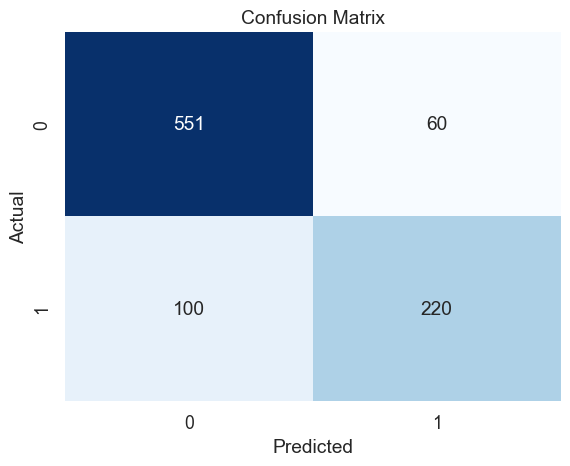



BEST ONE:  {'precision': 0.8463901689708141, 'recall': 0.9018003273322422, 'f1-score': 0.8732171156893819, 'support': 611.0, 'auc': 0.7946501636661212}


In [157]:
# SMOTE 後的資料
best_gbm_repo = gb_model(x_train_resampled, y_train_resampled, x_test, y_test)
print("\n\nBEST ONE: ", best_gbm_repo)

{'auc': 0.794721767594108,
 'f1-score': 0.8851195065535852,
 'precision': 0.8367346938775511,
 'recall': 0.939443535188216,
 'support': 611.0}


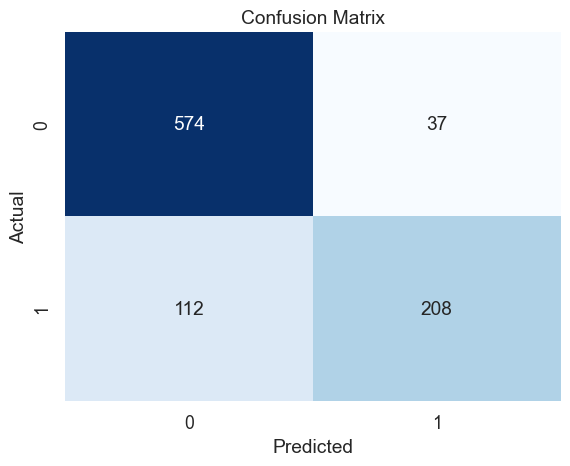

In [159]:
# 未使用SMOTE
repo = gb_model(x_train, y_train, x_test, y_test)
if repo['auc'] > best_gbm_repo['auc']:
    best_gbm_repo = repo
    print("\n\nBEST ONE: ", best_gbm_repo)

In [160]:
# XGBoost
from xgboost import XGBClassifier

def xgb_model(x_train, y_train, x_test, y_test):
    clf_xgb = XGBClassifier(random_state = seed)
    clf_xgb.fit(x_train, y_train)

    y_pred = clf_xgb.predict(x_test)
    report = eval_pipeline(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred)
    return report
    

{'auc': 0.8007518412438626,
 'f1-score': 0.8738019169329074,
 'precision': 0.8533541341653667,
 'recall': 0.8952536824877251,
 'support': 611.0}


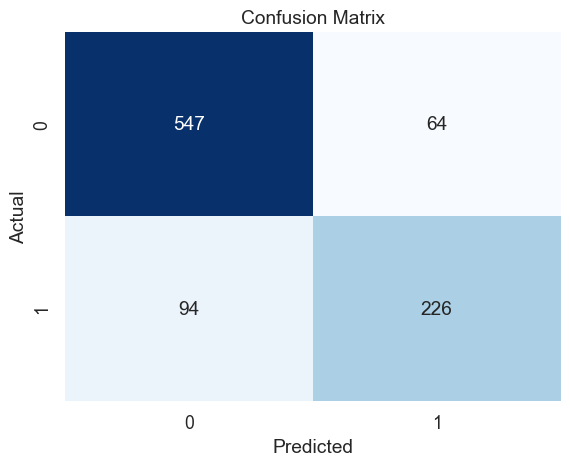

In [161]:
best_xgb_repo = xgb_model(x_train_resampled, y_train_resampled, x_test, y_test)

In [162]:
model_reports = {
    'svm': best_svm_repo,
    'mlp': best_mlp_repo,
    'gbm': best_gbm_repo,
    'xgb': best_xgb_repo
}
pprint(model_reports)

{'gbm': {'auc': 0.794721767594108,
         'f1-score': 0.8851195065535852,
         'precision': 0.8367346938775511,
         'recall': 0.939443535188216,
         'support': 611.0},
 'mlp': {'auc': 0.7828176145662847,
         'f1-score': 0.8774094063222823,
         'precision': 0.8294460641399417,
         'recall': 0.9312602291325696,
         'support': 611.0},
 'svm': {'auc': 0.7975475654664484,
         'f1-score': 0.8927756653992396,
         'precision': 0.8338068181818182,
         'recall': 0.9607201309328969,
         'support': 611.0},
 'xgb': {'auc': 0.8007518412438626,
         'f1-score': 0.8738019169329074,
         'precision': 0.8533541341653667,
         'recall': 0.8952536824877251,
         'support': 611.0}}


In [178]:
model_reports.values()

dict_values([{'precision': 0.8338068181818182, 'recall': 0.9607201309328969, 'f1-score': 0.8927756653992396, 'support': 611.0, 'auc': 0.7975475654664484}, {'precision': 0.8294460641399417, 'recall': 0.9312602291325696, 'f1-score': 0.8774094063222823, 'support': 611.0, 'auc': 0.7828176145662847}, {'precision': 0.8367346938775511, 'recall': 0.939443535188216, 'f1-score': 0.8851195065535852, 'support': 611.0, 'auc': 0.794721767594108}, {'precision': 0.8533541341653667, 'recall': 0.8952536824877251, 'f1-score': 0.8738019169329074, 'support': 611.0, 'auc': 0.8007518412438626}])

In [179]:
data.values()

dict_values([{'auc': 0.794721767594108, 'f1-score': 0.8851195065535852, 'precision': 0.8367346938775511, 'recall': 0.939443535188216, 'support': 611.0}, {'auc': 0.7828176145662847, 'f1-score': 0.8774094063222823, 'precision': 0.8294460641399417, 'recall': 0.9312602291325696, 'support': 611.0}, {'auc': 0.7975475654664484, 'f1-score': 0.8927756653992396, 'precision': 0.8338068181818182, 'recall': 0.9607201309328969, 'support': 611.0}, {'auc': 0.8007518412438626, 'f1-score': 0.8738019169329074, 'precision': 0.8533541341653667, 'recall': 0.8952536824877251, 'support': 611.0}])

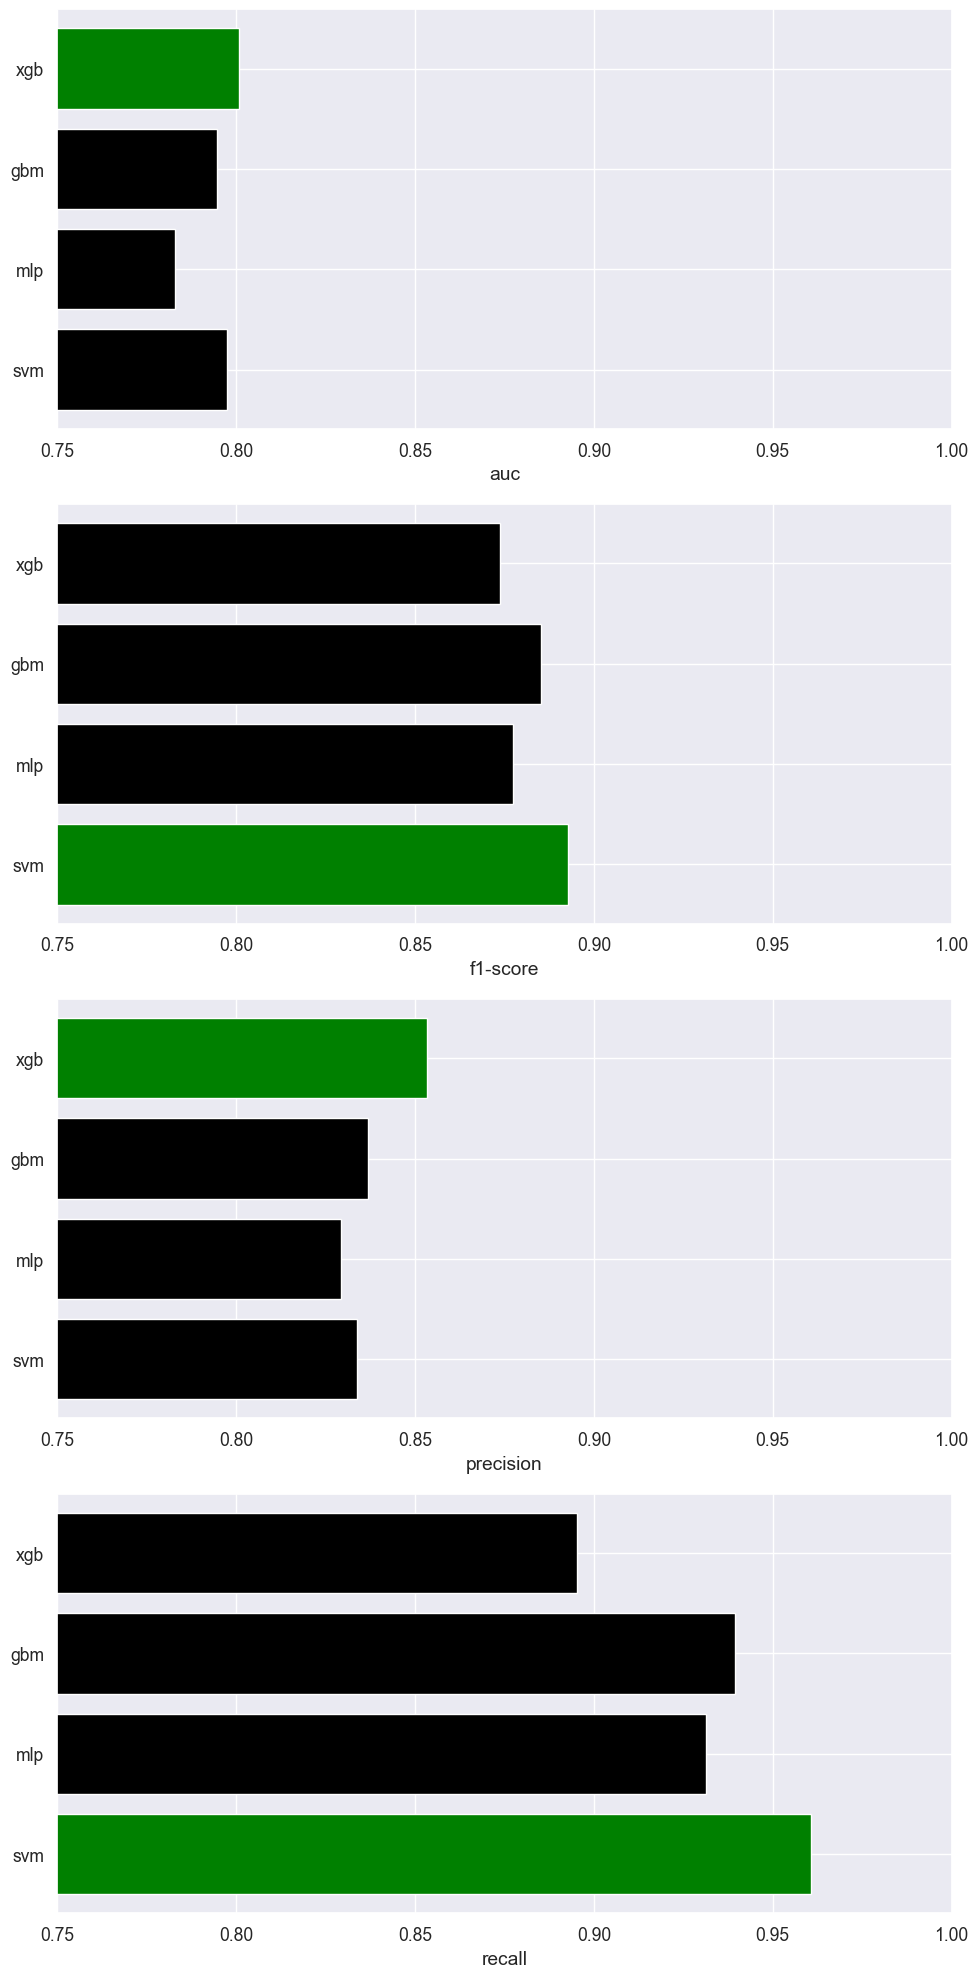

In [185]:
# Create subplots for each metric
fig, axs = plt.subplots(4, figsize=(10, 20))

metrics = ['auc', 'f1-score', 'precision', 'recall']

for i, metric in enumerate(metrics):
    values = [model[metric] for model in model_reports.values()]
    max_value = max(values)
    bar_colors = ['green' if value == max_value else 'black' for value in values]
    axs[i].barh(list(model_reports.keys()), values, color=bar_colors)
    axs[i].set_xlabel(metric)
    axs[i].set_xlim([0.75, 1])  # Adjust this as needed

plt.tight_layout()
plt.show()